# A. Prepare Dataset

## Dataset Description
### This dataset is historical data of stock prices of a specific business. Here I chose Microsoft stock data (MSFT).

### Dataset columns:
* ***Date:*** The date on which the stock prices were recorded. This is typically in the format of YYYY-MM-DD.

* ***Open:*** The opening price is the price at which the stock first trades upon the opening of an exchange on a given trading day. It is often influenced by the previous day's close price and pre-market trading activity.

* ***High:*** The highest price at which the stock traded during the trading day. This figure represents the peak price of the stock during the trading hours.

* ***Low:*** The lowest price at which the stock traded during the trading day. This figure represents the lowest point the stock reached during the trading hours.

* ***Close/ Last:*** The closing price is the price at which the stock last traded at the end of the trading day. This price is commonly used as a benchmark for daily performance.

* ***Volume:*** The volume represents the total number of shares traded during the trading day. This figure indicates the level of activity and liquidity for the stock.

## Step 1: Crawl Stock Data from Nasdaq

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
!apt-get update

In [ ]:
!apt-get install -y chromium-browser

In [ ]:
!apt install chromium-chromedriver

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

import pandas as pd

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-gpu')
user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.517 Safari/537.36'
chrome_options.add_argument('user-agent={0}'.format(user_agent))


In [ ]:
from selenium.common.exceptions import TimeoutException, NoSuchElementException, WebDriverException
import csv

driver = webdriver.Chrome(options=chrome_options)
driver.delete_all_cookies()

# URL của trang web
url = 'https://www.nasdaq.com/market-activity/stocks/MSFT/historical?page=1&rows_per_page=100&timeline=y10'
driver.get(url)
all_data = []
page_number = 1

def scrape_page(driver):
    rows = driver.find_elements(By.CSS_SELECTOR, '.table-row')
    data = []
    for row in rows:
        cells = row.find_elements(By.CSS_SELECTOR, '.table-cell')
        data.append([cell.text.strip() for cell in cells])
    return data

table_xpath = '//*[@class="simple-table-template table"]'

try:
    while True:
        print(f"Đang tải trang: {url}")
        driver.get(url)

        try:
            # Đợi trang tải xong và kiểm tra phần tử bảng có tồn tại
            WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.XPATH, table_xpath))
            )
            print("Đã tìm thấy bảng.")
        except TimeoutException:
            print("Timeout: Element không tồn tại trong khoảng thời gian chờ.")
            break
        except NoSuchElementException:
            print("Element không tồn tại.")
            break
        except WebDriverException as e:
            print(f"Lỗi WebDriver: {e}")
            break

        page_data = scrape_page(driver)
        if not page_data:
            break
        all_data.extend(page_data)
        page_number += 1
        url = f'https://www.nasdaq.com/market-activity/stocks/aapl/historical?page={page_number}&rows_per_page=100&timeline=y10'
except Exception as e:
    print(f"Lỗi không xác định: {e}")
finally:
    driver.quit()

    with open('historical_stock_data.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low'])
        writer.writerows(all_data)


## Step 1 - Plan B: Get dataset from API

In [9]:
import json
import pandas as pd

def parse_to_csv(data):
    data = json.loads(data.decode('utf-8'))

    headers = data['data']['tradesTable']['headers']
    rows = data['data']['tradesTable']['rows']

    columns = list(headers.values())

    parsed_rows = []
    for row in rows:
        parsed_row = [
            row['date'],
            row['close'].replace('$', '').replace(',', ''),
            row['volume'].replace(',', ''),
            row['open'].replace('$', '').replace(',', ''),
            row['high'].replace('$', '').replace(',', ''),
            row['low'].replace('$', '').replace(',', '')
        ]
        parsed_rows.append(parsed_row)

    df = pd.DataFrame(parsed_rows, columns=columns)

    df.to_csv('stock_data.csv', index=False)

    return df

In [10]:
import requests

url = f'https://api.nasdaq.com/api/quote/MSFT/historical?assetclass=stocks&fromdate=2014-08-01&limit=1000000000'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url, headers=headers)
if response.status_code == 200:
    data = response.content
    df = parse_to_csv(data)
else:
    print("Failed to retrieve data")


In [11]:
df

,Date,Close/Last,Volume,Open,High,Low
0,07/31/2024,418.35,42891370,420.495,421.775,412.21
1,07/30/2024,422.92,32687580,427.72,429.05,417.36
2,07/29/2024,426.73,15125840,431.58,432.15,424.7042
3,07/26/2024,425.27,23583840,418.20,428.915,417.27
4,07/25/2024,418.40,29943800,428.80,429.80,417.51
...,...,...,...,...,...,...
2511,08/07/2014,43.23,30300560,42.84,43.45,42.65
2512,08/06/2014,42.74,24625300,42.74,43.17,42.21
2513,08/05/2014,43.08,26258880,43.31,43.46,42.83
2514,08/04/2014,43.37,34200470,42.97,43.47,42.81


## Step 2: EDA

### Step 2.1. Understand the dataset structure & Distinguish Attributes

In [12]:
# check dataframe shape
df.shape

(2516, 6)

In [13]:
df.isna().sum()

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


In [14]:
# check data type of each column
df.dtypes

,0
Date,object
Close/Last,object
Volume,object
Open,object
High,object
Low,object


In [15]:
# convert data type from object to numerical values
df['Close/Last'] = pd.to_numeric(df['Close/Last'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce').astype('Int64')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

In [16]:
df.describe()

,Close/Last,Volume,Open,High,Low
count,2516.000000,2516.0,2516.000000,2516.000000,2516.000000
mean,171.838440,29295537.601351,171.783934,173.439283,170.057446
std,115.566707,13700957.723012,115.546888,116.596590,114.402134
min,40.290000,7425603.0,40.340000,40.740000,39.720000
25%,63.635000,21051915.0,63.727500,64.092500,63.297500
50%,136.440000,26220675.0,136.840000,137.710000,135.355050
75%,262.015000,33529697.5,261.252500,264.875000,258.775000
max,467.560000,202514100.0,467.000000,468.350000,464.460000


### Step 2.2. Univariate Analysis

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

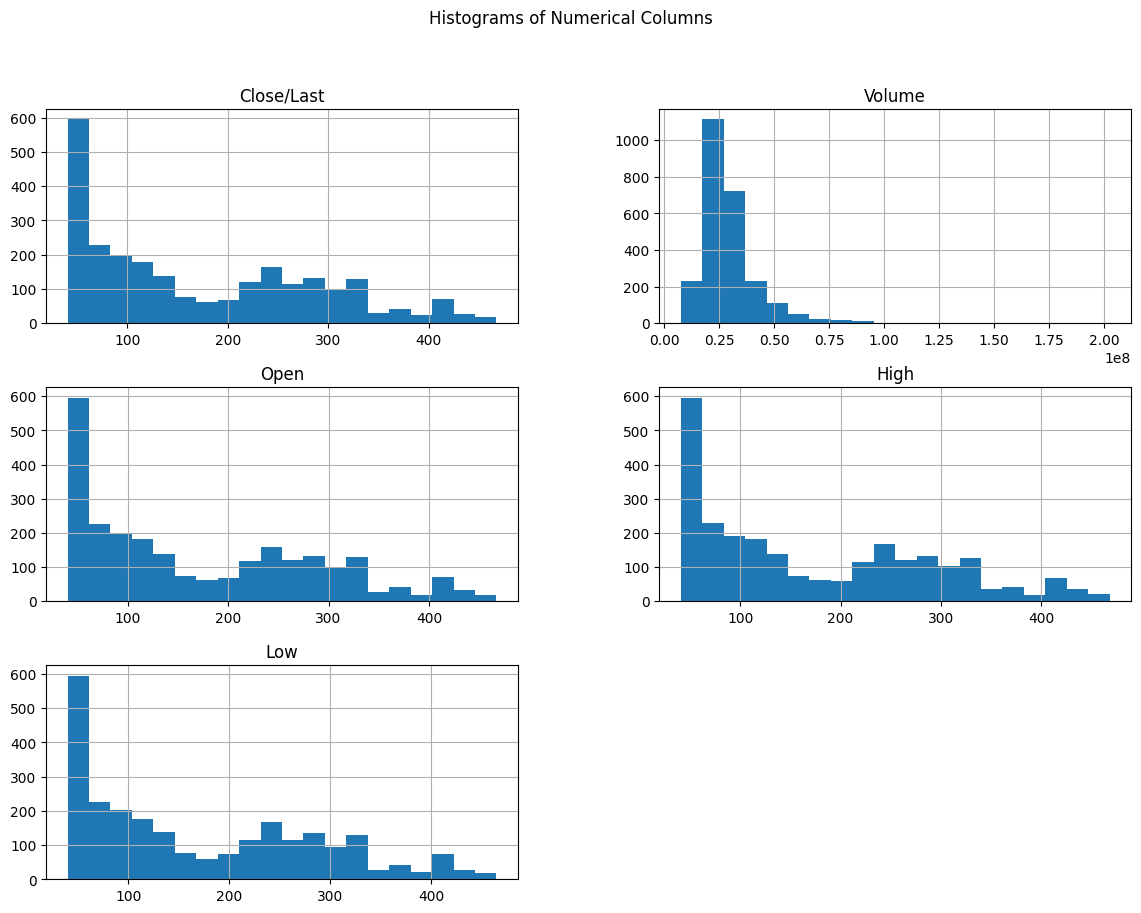

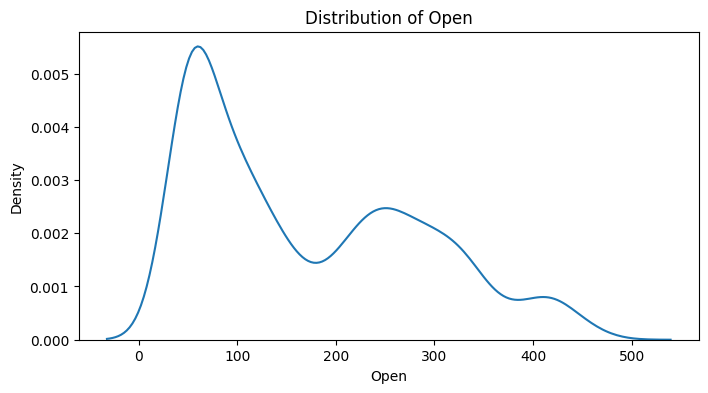

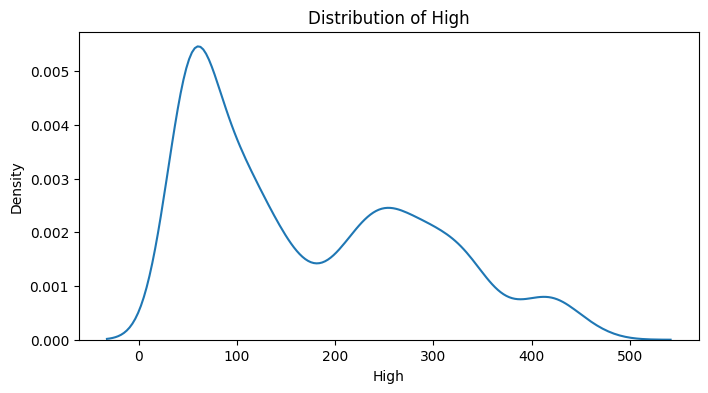

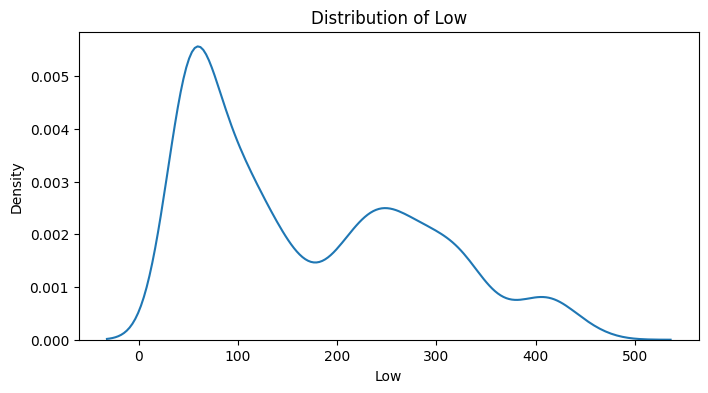

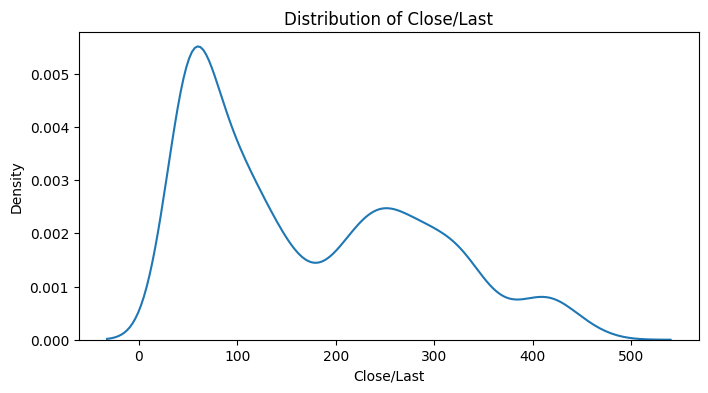

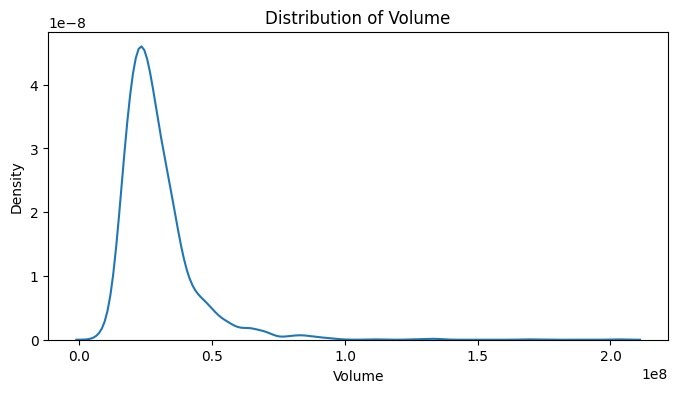

In [18]:
# Histograms
df.hist(bins=20, figsize=(14, 10))
plt.suptitle('Histograms of Numerical Columns')
plt.show()

for column in ['Open', 'High', 'Low', 'Close/Last', 'Volume']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[column])
    plt.title(f'Distribution of {column}')
    plt.show()

### Step 2.3. Bivariate Analysis

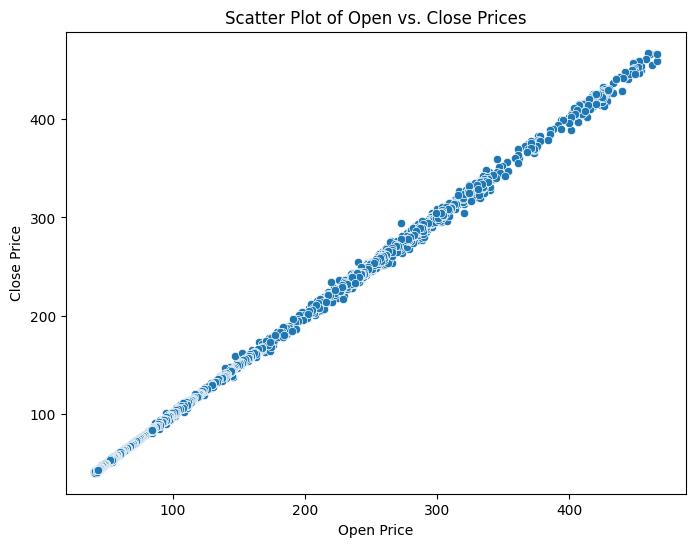

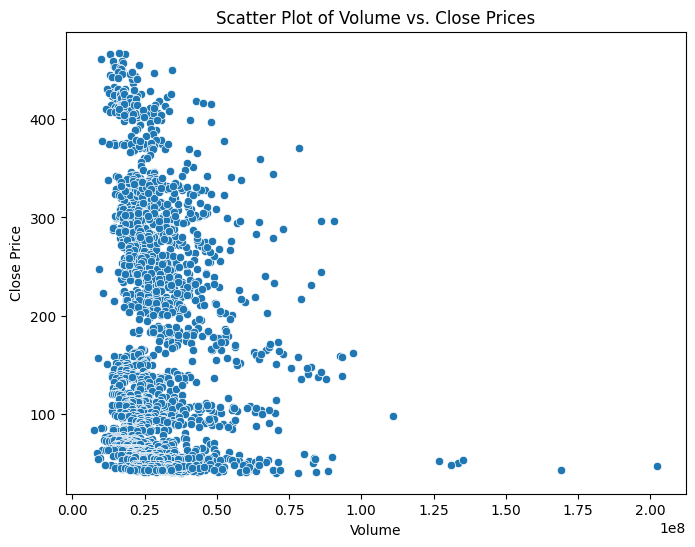

In [19]:
# Scatter plot between Open and Close prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Open', y='Close/Last', data=df)
plt.title('Scatter Plot of Open vs. Close Prices')
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.show()

# Scatter plot between Volume and Close prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Volume', y='Close/Last', data=df)
plt.title('Scatter Plot of Volume vs. Close Prices')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.show()


                Open      High       Low  Close/Last    Volume
Open        1.000000  0.999883  0.999866    0.999715 -0.138693
High        0.999883  1.000000  0.999833    0.999859 -0.134259
Low         0.999866  0.999833  1.000000    0.999877 -0.144171
Close/Last  0.999715  0.999859  0.999877    1.000000 -0.139846
Volume     -0.138693 -0.134259 -0.144171   -0.139846  1.000000


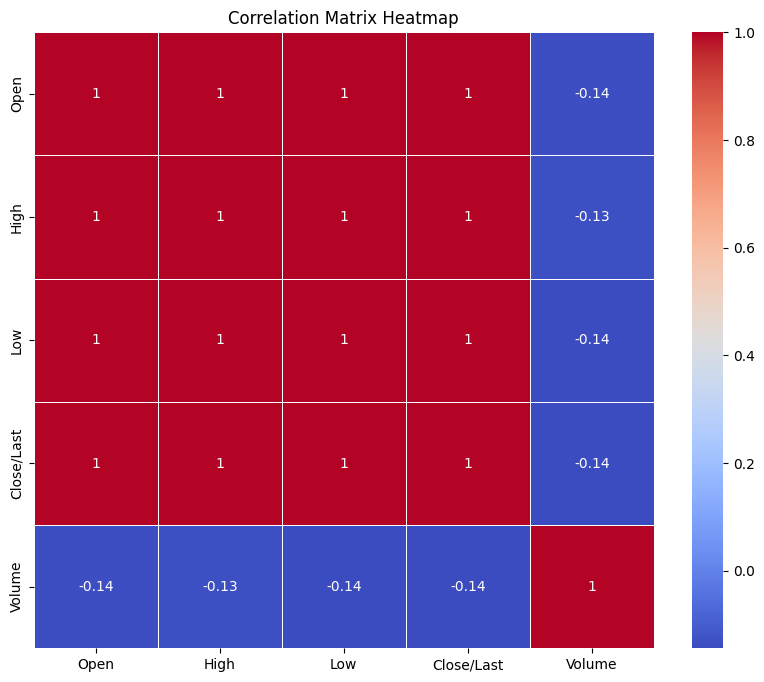

In [20]:
# Correlation matrix
corr_matrix = df[['Open', 'High', 'Low', 'Close/Last', 'Volume']].corr()
print(corr_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Step 2.4. Multivariate Statistics

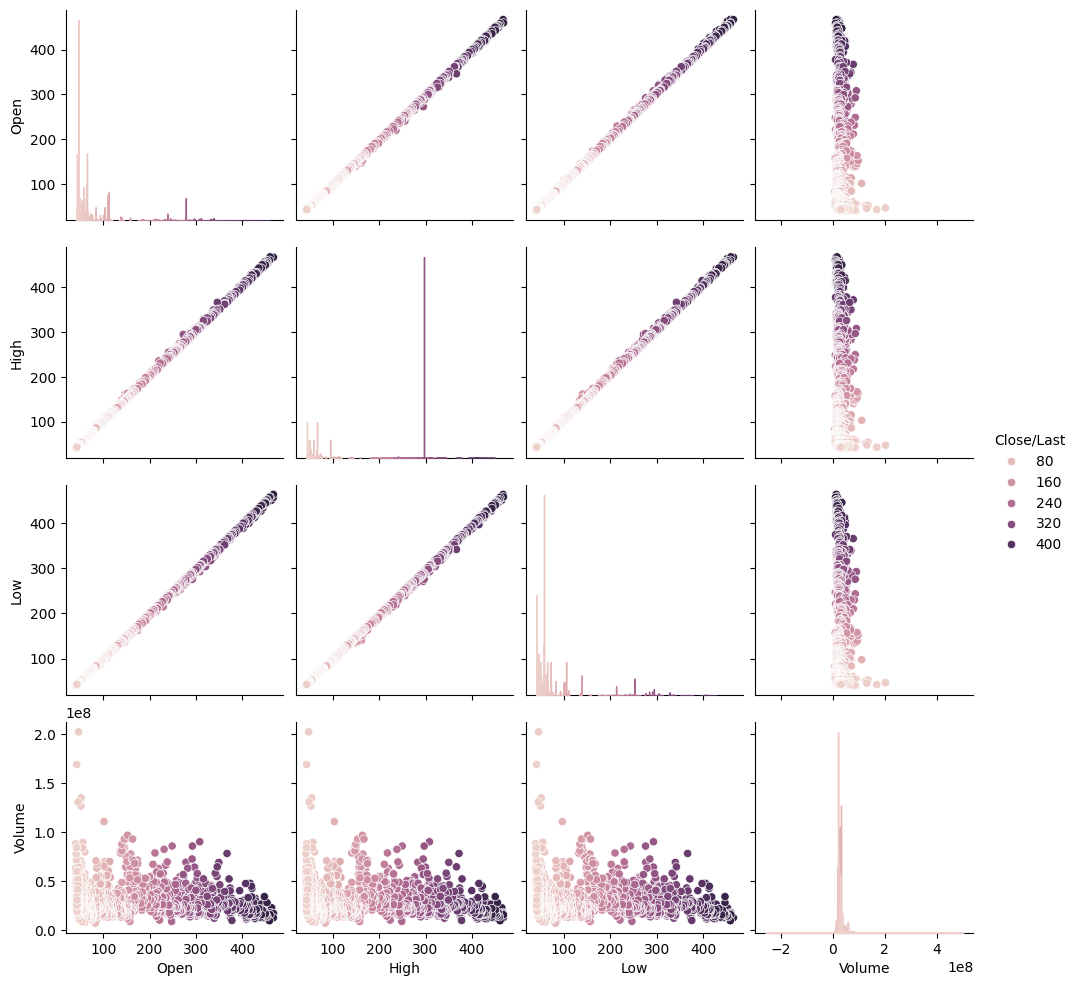

In [21]:
# Pairplot for selected features colored by target
sns.pairplot(df[['Open', 'High', 'Low', 'Close/Last',  'Volume']], hue='Close/Last')
plt.show()

### Step 2.5. Detect Abberant And Missing Values



In [22]:
df.isna().sum() # This stock dataset contains no missing values

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


In [23]:
duplicate_rows = df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")


Number of duplicate rows: 0


### Step 2.6. Detect Outliers



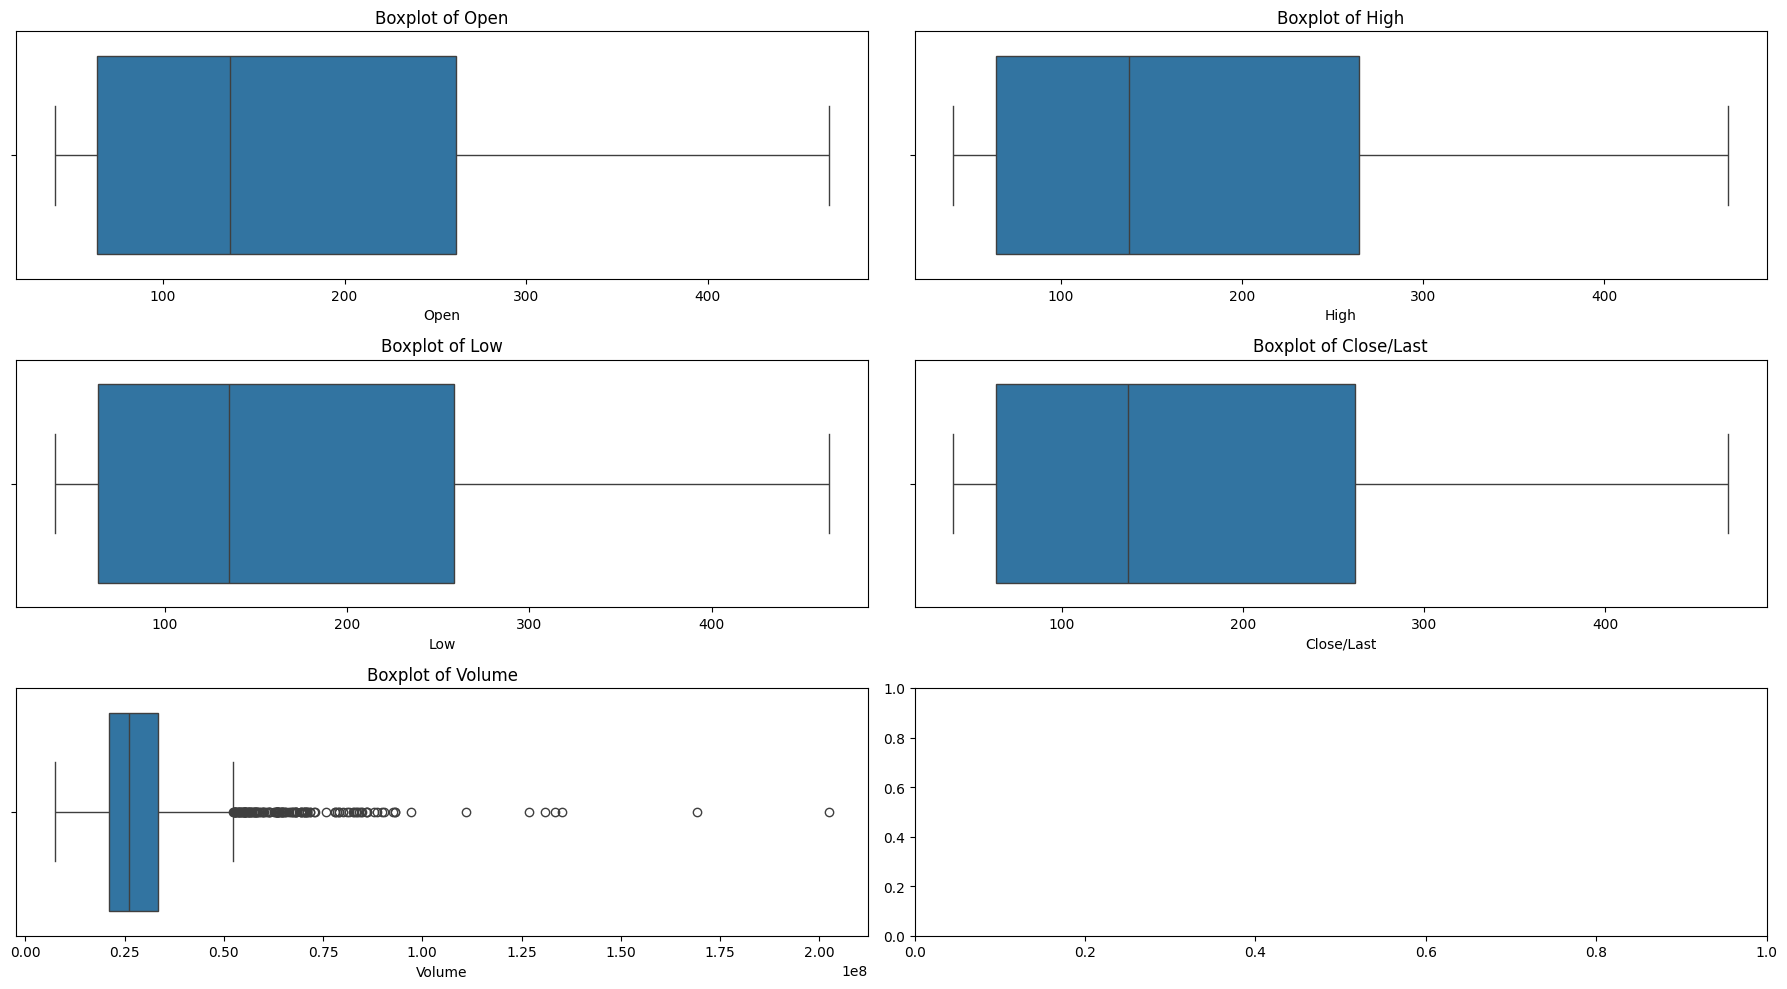

In [24]:
continuous_features = ['Open', 'High', 'Low', 'Close/Last', 'Volume']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

for i, feature in enumerate(continuous_features):
    row = i // 2
    col = i % 2
    sns.boxplot(x=df[feature], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature}')
    axes[row, col].set_xlabel(feature)

plt.tight_layout()
plt.show()

Comment: Only volume has outliers

## Step 3. Cleaning Data

### Step 3.1. Handle missing values

### Step 3.2. Handle outlier

In [ ]:
# from scipy.stats.mstats import winsorize

# # Apply winsorization
# df['Volume'] = winsorize(df['Volume'], limits=[0.05, 0.05])

### Step 3.3. Normalize and Standardize

# B. Apply Machine Learning Model

## Step 1: Importing the Libraries


In [25]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn. preprocessing import MinMaxScaler
from sklearn import linear_model
from keras. models import Sequential
from keras. layers import Dense
import keras. backend as K
from keras. callbacks import EarlyStopping
from keras.optimizers import Adam
from keras. models import load_model
from keras. layers import LSTM
from keras.utils import plot_model

## Step 2. Review data

In [26]:
df.shape

(2516, 6)

<Axes: >

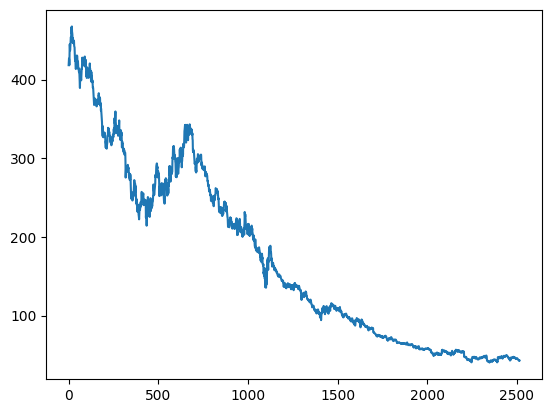

In [27]:
df['Close/Last'].plot()

In [28]:
#Set Target Variable
output_var = pd.DataFrame(df['Close/Last'])

#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

output_var.head()

,Close/Last
0,418.35
1,422.92
2,426.73
3,425.27
4,418.40


## Step 3. Scaling

In [29]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
0,0.891002,0.891081,0.876984,0.181793
1,0.907936,0.908094,0.889109,0.129490
2,0.916983,0.915343,0.906400,0.039470
3,0.885623,0.907778,0.888897,0.082825
4,0.910467,0.909848,0.889462,0.115426


## Step 4. Splitting to Training set and Test set

In [30]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## Step 5. Prepare model - LSTM

In [31]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


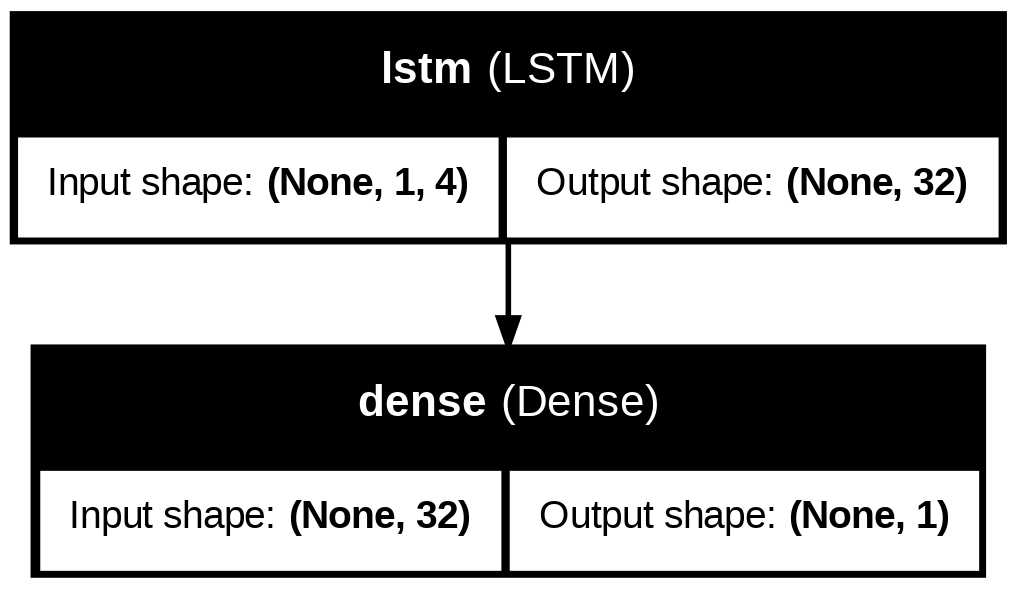

In [32]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [33]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 93175.5625
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 91544.2891
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 82792.6719
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 67629.1328
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51142.6016
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36246.3750
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24254.0234
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 15520.5996
Epoch 9/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9864.3818 
Epoch 10/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6163.1011
Epoch 11/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4065.0452
Epoch 12/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2830.9595
Epoch 13/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2055.2273
Epoch 14/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15

## Step 6. Use model

In [34]:
y_pred= lstm.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


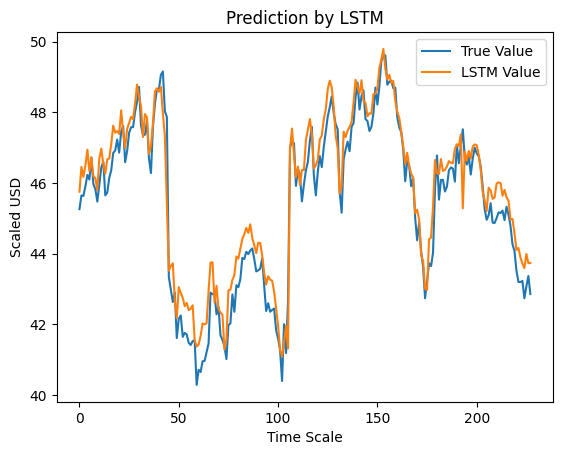

In [35]:
#Predicted vs True Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()